# Convert Data

Need to convert the test data to be vitessce complient
Looks like I'll need about 5 or so files

## Files for running in python notebook
1. The CODEX images
    - in python, can ome-zarr or ome-tiff. Need conversion for either,
        - ome-zarr: https://github.com/vitessce/vitessce-python/blob/main/demos/codeluppi-2018/src/convert_to_ome_zarr.py
        - ome.tiff: https://pypi.org/project/tifffile/
    - as of now, multi-image only works for ome.tiff
2. Segmentation masks
    - this can be ome-tiff
    - Try as JSON? This can remember cell associations
3. Expression values
4. Metadata/annotations
5. Dimension reductions

## Files for React app
Based on https://github.com/vitessce/vitessce-python/tree/main/demos/codeluppi-2018
1. Segmentations
    - JSON file that just has polygon coordinates. dump from dictionary that has cell ID keys
2. Cell meta
    - csv
    - reductions, cell centroids, cell IDs as index
3. Expression
    - simple csv. Cell ID as row, marker as columns, fill with X
4. Images
    - ome.zarr

NOTES:

- Not sure if the image transpose is necessary...


In [1]:
import tifffile as tff
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import anndata as ad
import pickle as pk
import scanpy as sc
from vitessce.data_utils import (
    multiplex_img_to_ome_zarr,
    optimize_adata,
    VAR_CHUNK_SIZE,
)
from vitessce import (
    VitessceConfig,
    Component as cm,
    CoordinationType as ct,
    AnnDataWrapper,
    OmeTiffWrapper,
    OmeZarrWrapper,
    CsvWrapper,
    MultiImageWrapper,
    AbstractWrapper,
)

from ome_zarr.format import FormatV02
from ome_zarr.writer import write_image
from ome_zarr.io import parse_url
import zarr

## Preparing full size HVCD1_reg1 data

In [2]:
channel_names = pd.read_table("/mnt/isilon/cscb/codex/pillaiv/SCTC-VP-15/code/forQuPath/channelNames_cohort2.txt", header=None)
channel_names = channel_names.iloc[:,0].to_list()

In [3]:
img = tff.TiffFile("/mnt/isilon/cscb/codex/pillaiv/SCTC-VP-15/code/forQuPath/Data/HVCD1_reg1/full_input_codex.qptiff")

In [4]:
img_dat = img.series[0].asarray()
img_dat = img_dat.astype(np.dtype("<u2"))
# img_dat = np.transpose(img_dat, axes=(0, 2, 1))

In [5]:
# trim it down to just 4 channels
#    DAPI, CD45, CD20, Ki67
markers = ['DAPI', 'CD45', 'CD20', 'Ki67']
marker_i = [np.where(np.array(channel_names) == m) for m in markers]
marker_i = np.array(marker_i).flatten()

In [10]:
img_dat_smaller = img_dat[marker_i,:,:]

In [27]:
# masks = tff.TiffFile("../data/test/bitmask_small.tiff")
# masks_dat = masks.series[0].asarray()
# masks_dat = masks_dat.astype(np.dtype("<u2"))
# masks_dat = np.transpose(masks_dat, axes=(1, 0))

In [31]:
masks_dat.shape

(2000, 2000)

In [9]:
img_dat_smaller.shape
img_dat_smaller = np.expand_dims(img_dat_smaller, axis=1)
img_dat_smaller = np.expand_dims(img_dat_smaller, axis=0)
img_dat_smaller.shape

(1, 4, 1, 9504, 10031)

### Making ome-tiff

In [36]:
# CODEX data
subresolutions = 1
pixelsize = 0.29  # micrometer, just using what was in example, probably wrong
with tff.TiffWriter('../data/test/converted/codex.ome.tif', ome=True) as tif:
    metadata={
        'axes': 'CYX',
        'Channel': {'Name': channel_names},
    }
    # options = dict(
    #     photometric='minisblack',
    #     tile=(128, 128),
    #     compression='jpeg',
    #     resolutionunit='CENTIMETER'
    # )
    tif.write(
        img_dat,
        # subifds=subresolutions,
        metadata=metadata,
    )

In [39]:
# Mask data
subresolutions = 1
pixelsize = 0.29  # micrometer, just using what was in example, probably wrong
with tff.TiffWriter('../data/test/converted/masks.ome.tif', ome=True) as tif:
    metadata={
        'axes': 'YX',
    }
    options = dict(
        photometric='minisblack',
        # tile=(128, 128),
        # compression='jpeg',
        # resolutionunit='CENTIMETER'
    )
    tif.write(
        masks_dat,
        # subifds=subresolutions,
        metadata=metadata,
        **options
    )

In [ ]:
# Mask csv
# see "Make_small_data" notebook

### Making ome-zarr
code from https://github.com/vitessce/vitessce-python/blob/main/demos/codeluppi-2018/src/convert_to_ome_zarr.py

In [ ]:
# # for channel_i, channel_name in enumerate(channel_names):
# #     img_arr[channel_i, :, :] = img_dat[channel_i]

# multiplex_img_to_ome_zarr(
#     img_dat,
#     markers,
#     "../data/test/converted/codex_img.ome.zarr",
#     img_name="Image",
#     chunks=(1, 512, 512),
#     axes="tczyx",
# )

In [8]:
img_dat_smaller.shape

(4, 9504, 10031)

In [11]:
# making an even smaller image file
multiplex_img_to_ome_zarr(
    img_dat_smaller,
    markers,
    "../data/test/converted/HVCD1_wrapper.ome.zarr",
    img_name="HVCD1_reg1",
    chunks=(1, 512, 512),
    axes="cyx",
)

### Making OME-NGFF (zarr)

In [54]:
path = "/mnt/isilon/cscb/codex/pillaiv/SCTC-VP-15/vitessce-gh-pages/data/test/converted/HVCD1_ngff_image.zarr"
size_xy = 512

In [55]:
store = parse_url(path, mode="w").store
root = zarr.group(store=store)

In [56]:
root.attrs["omero"] = {
    "name": "HVCD1 region1",
    "version": "0.3",
    "rdefs" : {},
    "channels": [{
        "color": "FFFFFF",
        "window": {"start": 0, "end": 240},
        "label": "DAPI",
        "active": True,
    },
    {
        "color": "9700FF",
        "window": {"start": 0, "end": 240},
        "label": "CD45",
        "active": True,
    },
    {
        "color": "FFDE00",
        "window": {"start": 0, "end": 240},
        "label": "CD20",
        "active": True,
    },
    {
        "color": "FF0000",
        "window": {"start": 0, "end": 240},
        "label": "Ki67",
        "active": True,
    }]
}

In [33]:
store

In [57]:
write_image(image=img_dat_smaller, 
            group=root, 
            axes="tczyx",
            storage_options=dict(chunks=(1, size_xy, size_xy)))

## Making JSON mask

In [2]:
from tqdm import tqdm
from scipy import signal, ndimage
from imantics import Polygons, Mask
from skimage.draw import disk
import json

In [3]:
def erode_mask(masks):
    masks_erode = masks.copy()
    for i in tqdm(np.arange(1, masks.shape[0]-1)):
        for j in np.arange(1, masks.shape[1]-1):
            if (masks[i,j-1] != masks[i,j+1]) and (min((masks[i,j-1], masks[i,j+1])) != 0):
                masks_erode[i,j] = 0
            if (masks[i-1,j] != masks[i+1,j]) and (min((masks[i-1,j], masks[i+1,j])) != 0):
                masks_erode[i,j] = 0
    # drop small cells
    unique, counts = np.unique(masks_erode, return_counts=True)
    c =np.asarray((unique, counts)).T
    drop_index = c[np.where(c[:,1] < 50),0]
    masks_erode[np.isin(masks_erode, drop_index[0])] = 0
    return masks_erode

In [14]:
with open("/mnt/isilon/cscb/codex/pillaiv/SCTC-VP-15/Data/CellSeg/output/visual_output/HVCD1_reg1_inputgrowth5mask.pckl", 'rb') as f:
    masks = pk.load(f)
masks.shape

(9504, 10023)

In [5]:
# masks = np.transpose(masks)

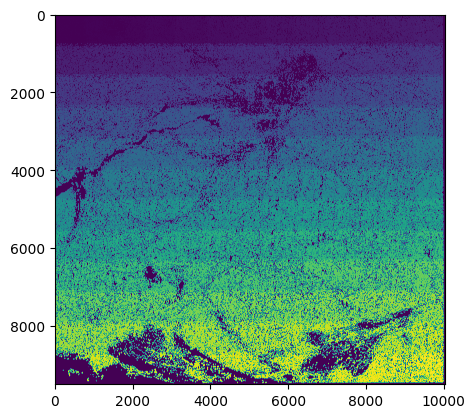

In [15]:
plt.imshow(masks)

In [6]:
masks_erode = erode_mask(masks)
masks_erode = ndimage.binary_erosion(masks_erode, structure=np.ones((3,3)), iterations=1).astype(int) * masks_erode

100%|██████████| 10021/10021 [02:48<00:00, 59.52it/s]


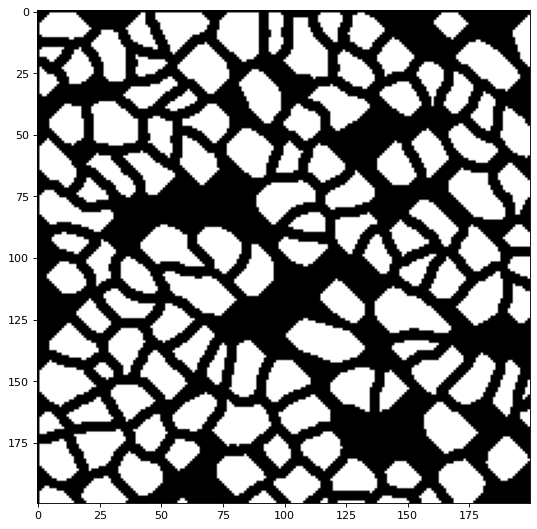

In [99]:
plt.figure(figsize=(12, 8), dpi=80)
# plt.imshow(dat >= global_thresh, cmap='gray')
plt.imshow(masks_erode[0:200,0:200] > 0, cmap='gray')

In [100]:
np.unique(masks_erode)[-5:]

array([233683, 233684, 233685, 233686, 233687])

In [106]:
# ##This will take forever...
# segments = {}
# for i in tqdm(np.unique(masks_erode)):
#     if i == 0:
#         continue
#     poly = Mask(masks_erode==i).polygons()
#     segments[str(i)] = poly.points[0].tolist() # should hopefully only be 1 cell...

  0%|          | 262/233658 [01:30<22:18:51,  2.91it/s]


KeyboardInterrupt: 

In [24]:
c = adata.obsm['centroids'][5]
np.flip(c)
# c
# adata.obsm['centroids'][5]

array([557.0373, 591.2985], dtype=float32)

In [25]:
# assuming adata is prepared
segments = {}
for i in tqdm(range(adata.shape[0])):
    coord = adata.obsm['centroids'][i]
    coord = np.flip(coord)
    cell_poly = [
        (coord[0]-5, coord[1]+5),
        (coord[0]-5, coord[1]-5),
        (coord[0]+5, coord[1]-5),
        (coord[0]+5, coord[1]+5),
    ]
    segments[adata.obs.index.values[i]] = cell_poly
    

100%|██████████| 233519/233519 [00:06<00:00, 38602.96it/s]


In [26]:
with open("../data/test/converted/hvcd1_r1_segmentations.json", "w") as f:
    json.dump(segments, f)

## Preparing the adata

Something strange happened to the expression values. Need to use the "SCTC-VP-15/outs/simple_h5ad/..." values.

Looks like most of the cells are still there. 
**! need to check for regions were tiles were discarded !**
- maybe match on coordinates?



### as zarr

In [12]:
adata_cd = ad.read_h5ad("/mnt/isilon/cscb/codex/pillaiv/SCTC-VP-15/code/CD_analysis/aSMA_CD21_analysis/all_regions_dat.h5ad")
adata_cd.obs.head()

,Unnamed: 0,orig.ident,nCount_originalexp,nFeature_originalexp,Reg,Tile.Row,Tile.Col,Tile.Z,In.Tile.Y,In.Tile.X,...,n_genes_by_counts,total_counts,nCount_raw,nFeature_raw,cell_type_pred_knn,cell_type_pred_knn_prob,motif,index_info,new_pheno,region
56787_MCD1_reg1,57478.0,SeuratProject,-1.373537,15,0,1,1,0,3062.176166,463.777202,...,42,479.112274,10000.000075,42,CD4_T_Cell,1.0,Motif_3,56787,CD4_T_Cell,MCD1_reg1
56788_MCD1_reg1,57479.0,SeuratProject,-0.558318,14,0,1,1,0,2779.607930,492.026432,...,44,639.404785,9999.999802,44,CD4_T_Cell,1.0,Motif_8,56788,CD4_T_Cell,MCD1_reg1
56790_MCD1_reg1,57481.0,SeuratProject,-5.667793,12,0,1,1,0,2858.248521,436.088757,...,44,597.172546,9999.999699,44,CD8_T_Cell,1.0,Motif_8,56790,CD8_T_Cell,MCD1_reg1
56793_MCD1_reg1,57484.0,SeuratProject,-4.822797,13,0,1,1,0,3125.950739,254.541872,...,42,555.201355,10000.000843,42,Lymphatics,0.6,Motif_8,56793,Lymphatics,MCD1_reg1
56798_MCD1_reg1,57489.0,SeuratProject,0.979234,20,0,1,1,0,2871.262295,141.147541,...,43,450.782928,9999.999804,43,Treg,0.2,Motif_8,56798,Treg,MCD1_reg1


In [ ]:
# adata_hvcd = ad.read_zarr("../data/test/converted/HVCD1_adata.zarr/")

In [ ]:
adata_hvcd1 = adata_cd[adata_cd.obs['region'] == "HVCD1_reg1",:]
adata_hvcd1.obs.head()

,Unnamed: 0,orig.ident,nCount_originalexp,nFeature_originalexp,Reg,Tile.Row,Tile.Col,Tile.Z,In.Tile.Y,In.Tile.X,...,n_genes_by_counts,total_counts,nCount_raw,nFeature_raw,cell_type_pred_knn,cell_type_pred_knn_prob,motif,index_info,new_pheno,region
0_HVCD1_reg1,1.0,SeuratProject,3.029314,24,0,1,1,0,403.341837,631.642857,...,43,622.045105,9999.999453,43,CD4_T_Cell,0.6,Motif_6,0,CD4_T_Cell,HVCD1_reg1
1_HVCD1_reg1,2.0,SeuratProject,-0.085674,18,0,1,1,0,648.027149,545.506787,...,44,746.450439,10000.000837,44,Endothelial,1.0,Motif_7,1,Endothelial,HVCD1_reg1
2_HVCD1_reg1,3.0,SeuratProject,-0.183910,19,0,1,1,0,767.573913,606.704348,...,44,851.487671,9999.999832,44,Macrophage,0.6,Motif_7,2,Macrophage,HVCD1_reg1
3_HVCD1_reg1,4.0,SeuratProject,2.369776,21,0,1,1,0,21.823529,182.514706,...,44,789.787537,9999.999268,44,Endothelial,0.8,Motif_8,3,Endothelial,HVCD1_reg1
4_HVCD1_reg1,5.0,SeuratProject,0.127480,18,0,1,1,0,501.349462,663.370968,...,42,384.309753,10000.000068,42,Plasma_prolif,1.0,Motif_6,4,myeloid,HVCD1_reg1


In [24]:
np.quantile(adata_hvcd1.X[:,12], np.arange(0,1,0.2))

ArrayView([0.        , 5.46014013, 5.64843836, 5.78738012, 5.94061012])

In [25]:
# adata_hvcd1.raw = adata_hvcd1
# sc.pp.scale(adata_hvcd1, max_value=10)
sc.tl.pca(adata_hvcd1, svd_solver='arpack')
sc.pp.neighbors(adata_hvcd1)
sc.tl.umap(adata_hvcd1)

/mnt/isilon/cscb/software/anaconda3/envs/vitessce/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


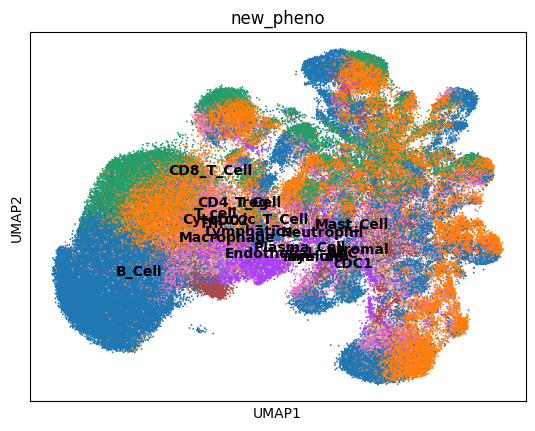

In [26]:
sc.pl.umap(adata_hvcd1, color='new_pheno', legend_loc='on data', size = 7)

In [19]:
# adata = sc.read_h5ad("/mnt/isilon/cscb/codex/pillaiv/SCTC-VP-15/outs/neighborhood_analysis/HVCD1_reg1/gated_dat_full.h5ad")
# adata = sc.read_h5ad("/mnt/isilon/cscb/codex/pillaiv/SCTC-VP-15/outs/simple_h5ad/HVCD1_reg1_statistics_growth5_comp.h5ad")
adata

AnnData object with n_obs × n_vars = 233519 × 44
    obs: 'Reg', 'Tile Row', 'Tile Col', 'Tile Z', 'In-Tile Y', 'In-Tile X', 'Absolute Y', 'Absolute X', 'Cell Size', 'n_genes_by_counts', 'total_counts', 'new_pheno'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mean', 'std'
    uns: 'pca', 'neighbors', 'paga', 'new_pheno_sizes', 'umap', 'new_pheno_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [107]:
adata.obs.tail()

,Reg,Tile Row,Tile Col,Tile Z,In-Tile Y,In-Tile X,Absolute Y,Absolute X,Cell Size,n_genes_by_counts,total_counts,new_pheno,motif,motif_name
Cell,,,,,,,,,,,,,,
233683.0,0.0,1.0,1.0,0.0,9060.055944,9897.279720,9060.055944,9897.279720,312.0,26,142.266907,Endothelial,Motif_2,B cell follicle
233684.0,0.0,1.0,1.0,0.0,8765.981481,9876.055556,8765.981481,9876.055556,163.0,43,240.357071,B_Cell,Motif_2,B cell follicle
233685.0,0.0,1.0,1.0,0.0,9009.780702,9891.991228,9009.780702,9891.991228,210.0,44,276.185577,B_Cell,Motif_2,B cell follicle
233686.0,0.0,1.0,1.0,0.0,9147.606383,9507.127660,9147.606383,9507.127660,247.0,43,299.330139,CD4_T_Cell,Motif_1,interfollicular; CD4 T dom.
233687.0,0.0,1.0,1.0,0.0,9388.666667,9707.944444,9388.666667,9707.944444,230.0,41,326.834412,CD4_T_Cell,Motif_1,interfollicular; CD4 T dom.


In [75]:
adata.obs['new_pheno'] = adata_hvcd1.obs['new_pheno'].values
adata.obs['motif'] = adata_hvcd1.obs['motif'].values

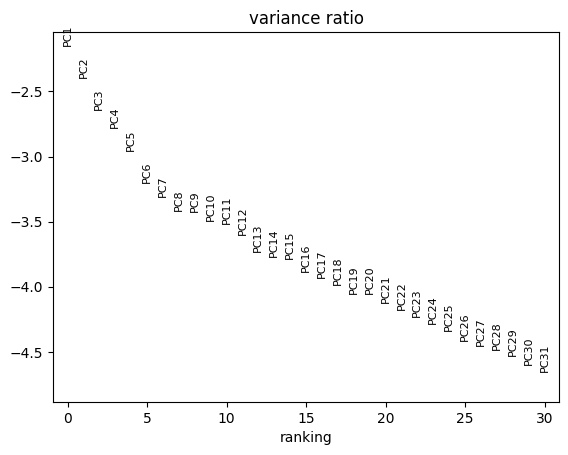

In [20]:
sc.pl.pca_variance_ratio(adata, log=True)

In [50]:
adata_small = adata[np.random.choice(adata.shape[0], 20000),:]

In [69]:
# sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10)
sc.tl.paga(adata, groups="new_pheno")
sc.pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
# sc.pp.neighbors(adata_small, n_neighbors=10)
# sc.tl.paga(adata_small, groups="new_pheno")
# sc.pl.paga(adata_small, plot=True)

In [70]:
sc.tl.umap(adata, init_pos='paga', spread=5, min_dist=0.01)
# sc.tl.umap(adata, spread=10, min_dist=1)

/mnt/isilon/cscb/software/anaconda3/envs/vitessce/lib/python3.8/site-packages/umap/umap_.py:1356: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


/mnt/isilon/cscb/software/anaconda3/envs/vitessce/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


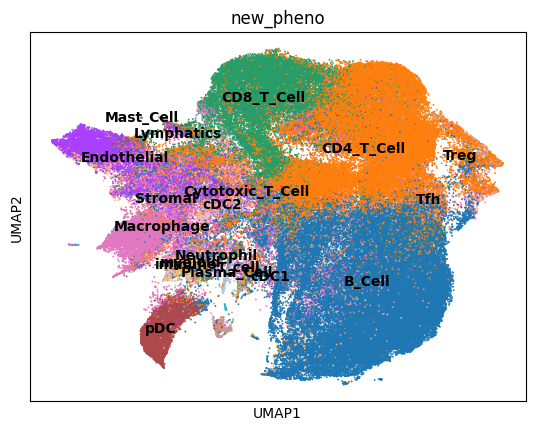

In [135]:
sc.pl.umap(adata, color='new_pheno', legend_loc='on data', size = 7)

In [73]:
adata

AnnData object with n_obs × n_vars = 233519 × 44
    obs: 'Reg', 'Tile Row', 'Tile Col', 'Tile Z', 'In-Tile Y', 'In-Tile X', 'Absolute Y', 'Absolute X', 'Cell Size', 'n_genes_by_counts', 'total_counts', 'new_pheno'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mean', 'std'
    uns: 'pca', 'neighbors', 'paga', 'new_pheno_sizes', 'umap', 'new_pheno_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [ ]:
# adding some more metadata

In [74]:
adata.obsm['centroids'] = adata.obs.loc[:,['Absolute Y','Absolute X']].to_numpy()

In [76]:
motif_anno = {
    "Motif_0":"mantle, unknown",
    "Motif_1":"interfollicular; CD4 T dom.",
    "Motif_2":"B cell follicle",
    "Motif_3":"interfollicular; Mac, T cell",
    "Motif_4":"follicle; FDC-B cell",
    "Motif_5":"interfollicular; Mac, cDC, CD4 T",
    "Motif_6":"pDC dom.",
    "Motif_7":"endothelial",
    "Motif_8":"endothelial; MCD pheno",
    "Motif_9":"endothelial; perifollicular",
    "Motif_10":"plasma cell",
    "Motif_11":"stromal, unknown, follicle"
}
adata.obs["motif_name"] = adata.obs["motif"].apply(lambda x: motif_anno[x])

In [53]:
# rename cells to hopefully match the segmentation masks...
# adata_hvcd1.obs_names = adata_hvcd1.obs["Unnamed: 0"].astype(int)

/mnt/isilon/cscb/software/anaconda3/envs/vitessce/lib/python3.8/site-packages/anndata/_core/anndata.py:872: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [1, 2, 3, 4, 5]

    Inferred to be: integer

  names = self._prep_dim_index(names, "obs")


In [20]:
# with open("../data/test/raw/test_segmentations.pkl","rb") as f:
#     segments = pk.load(f)
# adata_small.obsm["segments"] = segments

In [77]:
adata.obs.head()

,Reg,Tile Row,Tile Col,Tile Z,In-Tile Y,In-Tile X,Absolute Y,Absolute X,Cell Size,n_genes_by_counts,total_counts,new_pheno,motif,motif_name
Cell,,,,,,,,,,,,,,
1.0,0.0,1.0,1.0,0.0,403.341837,631.642857,403.341837,631.642857,397.0,43,622.045105,CD4_T_Cell,Motif_6,pDC dom.
2.0,0.0,1.0,1.0,0.0,648.027149,545.506787,648.027149,545.506787,834.0,44,746.450439,Endothelial,Motif_7,endothelial
3.0,0.0,1.0,1.0,0.0,767.573913,606.704348,767.573913,606.704348,365.0,44,851.487671,Macrophage,Motif_7,endothelial
4.0,0.0,1.0,1.0,0.0,21.823529,182.514706,21.823529,182.514706,393.0,44,789.787537,Endothelial,Motif_8,endothelial; MCD pheno
5.0,0.0,1.0,1.0,0.0,501.349462,663.370968,501.349462,663.370968,316.0,42,384.309753,myeloid,Motif_6,pDC dom.


In [131]:
# adata_hvcd1.obs.head()
adata.obs.tail()

,Reg,Tile Row,Tile Col,Tile Z,In-Tile Y,In-Tile X,Absolute Y,Absolute X,Cell Size,n_genes_by_counts,total_counts,new_pheno,motif,motif_name
Cell,,,,,,,,,,,,,,
233683.0,0.0,1.0,1.0,0.0,9060.055944,9897.279720,9060.055944,9897.279720,312.0,26,142.266907,Endothelial,Motif_2,B cell follicle
233684.0,0.0,1.0,1.0,0.0,8765.981481,9876.055556,8765.981481,9876.055556,163.0,43,240.357071,B_Cell,Motif_2,B cell follicle
233685.0,0.0,1.0,1.0,0.0,9009.780702,9891.991228,9009.780702,9891.991228,210.0,44,276.185577,B_Cell,Motif_2,B cell follicle
233686.0,0.0,1.0,1.0,0.0,9147.606383,9507.127660,9147.606383,9507.127660,247.0,43,299.330139,CD4_T_Cell,Motif_1,interfollicular; CD4 T dom.
233687.0,0.0,1.0,1.0,0.0,9388.666667,9707.944444,9388.666667,9707.944444,230.0,41,326.834412,CD4_T_Cell,Motif_1,interfollicular; CD4 T dom.


In [9]:
zarr_filepath = "/mnt/isilon/cscb/codex/pillaiv/SCTC-VP-15/vitessce-gh-pages/data/test/converted/HVCD1_adata.zarr"

In [84]:
adata_out = optimize_adata(
    adata,
    obs_cols=["new_pheno","motif_name"],
    obsm_keys=["X_umap", "X_pca","centroids"],
    optimize_X=True,
)
adata_out.write_zarr(zarr_filepath, chunks=[adata_out.shape[0], VAR_CHUNK_SIZE])

In [10]:
adata = ad.read_zarr(zarr_filepath)
adata

AnnData object with n_obs × n_vars = 233519 × 44
    obs: 'new_pheno', 'motif_name'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mean', 'std'
    obsm: 'X_pca', 'X_umap', 'centroids'
    varm: 'PCs'

### as CSVs

In [28]:
# making a csv output
cells_df = adata_small.obs[["Unnamed: 0", "Absolute.Y", "Absolute.X", "new_pheno", "motif"]]
cells_df["Unnamed: 0"] = cells_df["Unnamed: 0"].astype(int)
cells_df.set_index("Unnamed: 0", inplace=True)
cells_df.index = cells_df.index.rename("cell_id")
cells_df.tail()

/tmp/ipykernel_93097/2192715062.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cells_df["Unnamed: 0"] = cells_df["Unnamed: 0"].astype(int)


,Absolute.Y,Absolute.X,new_pheno,motif
cell_id,,,,
41524,1833.046512,1941.697674,B_Cell,Motif_1
41525,1712.140741,1583.829630,B_Cell,Motif_1
41526,1859.259542,2002.175573,B_Cell,Motif_1
41527,1631.783784,1839.081081,B_Cell,Motif_1
41530,1581.342105,1512.394737,B_Cell,Motif_1


In [29]:
cells_df['UMAP_1'] = adata_small.obsm['X_umap'][:,0]
cells_df['UMAP_2'] = adata_small.obsm['X_umap'][:,1]

/tmp/ipykernel_93097/3242105401.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cells_df['UMAP_1'] = adata_small.obsm['X_umap'][:,0]
/tmp/ipykernel_93097/3242105401.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cells_df['UMAP_2'] = adata_small.obsm['X_umap'][:,1]


In [31]:
matrix_df = pd.DataFrame(
    index=cells_df.index.values.tolist(),
    columns=adata_small.var.index.tolist(),
    data=adata_small.raw.X
)
matrix_df.index = matrix_df.index.rename("cell_id")

In [32]:
cells_df.to_csv("../data/test/converted/test_cells.csv", index=True)
matrix_df.to_csv("../data/test/converted/test_matrix.csv", index=True)

## Making the widget

In [7]:
# Option with ome-zarr
vc = VitessceConfig(schema_version="1.0.15", name='CODEX', description='Testing small slice of CODEX image')
dataset = vc.add_dataset(name='R1reg1').add_object(
    OmeZarrWrapper(img_path="/mnt/isilon/cscb/codex/pillaiv/SCTC-VP-15/vitessce-gh-pages/data/test/converted/codex_img.ome.zarr")
)
spatial = vc.add_view(cm.SPATIAL, dataset=dataset)
status = vc.add_view(cm.STATUS, dataset=dataset)
lc = vc.add_view(cm.LAYER_CONTROLLER, dataset=dataset).set_props(disableChannelsIfRgbDetected=True)
vc.layout(spatial | lc / status);

In [9]:
# Option with ome.tiff
vc = VitessceConfig(schema_version="1.0.15", name='CODEX', description='Testing small slice of CODEX image')
dataset = vc.add_dataset(name='R1reg1').add_object(
    MultiImageWrapper(
        image_wrappers=[
            OmeTiffWrapper(img_path='/mnt/isilon/cscb/codex/pillaiv/SCTC-VP-15/vitessce-gh-pages/data/test/raw/codex.ome.tif', name='Image'),
            OmeTiffWrapper(img_path='/mnt/isilon/cscb/codex/pillaiv/SCTC-VP-15/vitessce-gh-pages/data/test/raw/masks.ome.tif', name='Mask', is_bitmask=True),
        ]
 )
)
# making a UMAP
# cell_dataset = vc.add_dataset(name='R1reg1_obs').add_object(AnnDataWrapper(
#     adata_path=zarr_filepath,
#     obs_set_paths=["obs/new_pheno", "obs/motif"],
#     obs_set_names=["phenotype", "motif"],
#     obs_embedding_paths=["obsm/X_umap", "obsm/X_pca"],
#     obs_embedding_names=["UMAP", "PCA"],
#     obs_feature_matrix_path="X",
#     # obs_locations_path=["obsm/centroids"]
# ))
dataset = dataset.add_object(AnnDataWrapper(
    adata_path=zarr_filepath,
    obs_set_paths=["obs/new_pheno", "obs/motif"],
    obs_set_names=["phenotype", "motif"],
    obs_embedding_paths=["obsm/X_umap", "obsm/X_pca"],
    obs_embedding_names=["UMAP", "PCA"],
    obs_feature_matrix_path="X",
    # obs_locations_path=["obsm/centroids"]
))

# seg_data = vc.add_dataset(name="B").add_file(

spatial = vc.add_view(cm.SPATIAL, dataset=dataset)
# status = vc.add_view(cm.STATUS, dataset=dataset)
lc = vc.add_view(cm.LAYER_CONTROLLER, dataset=dataset)
umap = vc.add_view(cm.SCATTERPLOT, dataset=dataset, mapping="UMAP")
cell_sets = vc.add_view(cm.OBS_SETS, dataset=dataset)
genes = vc.add_view(cm.FEATURE_LIST, dataset=dataset)
vc.layout(spatial | umap | lc / cell_sets);

In [4]:
# # Option with ome.tiff and json segmentations
# dataset = vc.add_dataset(name='R1reg1').add_object(
#     MultiImageWrapper(
#         image_wrappers=[
#             OmeTiffWrapper(img_path='/mnt/isilon/cscb/codex/pillaiv/SCTC-VP-15/vitessce-gh-pages/data/test/converted/codex.ome.tif', name='Image'),
#             OmeTiffWrapper(img_path='/mnt/isilon/cscb/codex/pillaiv/SCTC-VP-15/vitessce-gh-pages/data/test/converted/masks.ome.tif', name='Mask', is_bitmask=True),
#         ]
#  )
# )


# spatial = vc.add_view(cm.SPATIAL, dataset=dataset)
# status = vc.add_view(cm.STATUS, dataset=dataset)
# lc = vc.add_view(cm.LAYER_CONTROLLER, dataset=dataset).set_props(disableChannelsIfRgbDetected=True)
# vc.layout(spatial | lc / status);

In [6]:
vw = vc.widget()
print(vw)

VitessceWidget(config={'version': '1.0.15', 'name': 'CODEX', 'description': 'Testing small slice of CODEX image', 'datasets': [{'uid': 'A', 'name': 'R1reg1', 'files': [{'fileType': 'raster.json', 'options': {'schemaVersion': '0.0.2', 'usePhysicalSizeScaling': False, 'images': [{'name': 'Image', 'type': 'ome-tiff', 'url': 'http://localhost:8000/A/0/8dd18301-c8d5-448c-a6ae-9f1b3674672e', 'metadata': {'omeTiffOffsetsUrl': 'http://localhost:8000/A/0/2c362cab-8604-40aa-9aa6-6a8b0c72aac2', 'isBitmask': False}}, {'name': 'Mask', 'type': 'ome-tiff', 'url': 'http://localhost:8000/A/0/d501447b-100c-4933-a26b-7abb33884e4e', 'metadata': {'omeTiffOffsetsUrl': 'http://localhost:8000/A/0/fa36ae30-c4eb-43d9-918d-043e43238556', 'isBitmask': True}}], 'renderLayers': ['Image', 'Mask']}}]}, {'uid': 'B', 'name': 'R1reg1_obs', 'files': [{'fileType': 'anndata.zarr', 'url': 'http://localhost:8000/B/0/e40a1d90-2dd4-4dce-a886-950bc9f22ffb', 'options': {'obsEmbedding': [{'path': 'obsm/X_umap', 'dims': [0, 1], 'e

In [10]:
vc.display()

In [5]:
import math
import itertools as it
import copy
from fractions import Fraction

In [3]:
m = M = [[0,1,0,0,0,1],[4,0,0,3,2,0],[0]*6,[0]*6,[0]*6,[0]*6]
# M = [[0,2,1,0,0],[0,0,0,3,4],[0]*5,[0]*5,[0]*5]
# m = [[0,1,0,2,2],[2,0,3,4,0],[1,4,0,0,5],[0]*5,[0]*5]
m

[[0, 1, 0, 0, 0, 1],
 [4, 0, 0, 3, 2, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0]]

In [6]:
s_terminal = [s for s in list(range(len(m))) if sum(m[s]) == 0]
for s in s_terminal:
    m[s][s] = 1


M_frac = []
for i in range(len(m)):
    if sum(m[i]) != 0:
        M_frac.append([Fraction(n, sum(m[i])) for n in m[i]])
    else:
        M_frac.append([Fraction(0)]*len(m))
M_frac

[[Fraction(0, 1),
  Fraction(1, 2),
  Fraction(0, 1),
  Fraction(0, 1),
  Fraction(0, 1),
  Fraction(1, 2)],
 [Fraction(4, 9),
  Fraction(0, 1),
  Fraction(0, 1),
  Fraction(1, 3),
  Fraction(2, 9),
  Fraction(0, 1)],
 [Fraction(0, 1),
  Fraction(0, 1),
  Fraction(1, 1),
  Fraction(0, 1),
  Fraction(0, 1),
  Fraction(0, 1)],
 [Fraction(0, 1),
  Fraction(0, 1),
  Fraction(0, 1),
  Fraction(1, 1),
  Fraction(0, 1),
  Fraction(0, 1)],
 [Fraction(0, 1),
  Fraction(0, 1),
  Fraction(0, 1),
  Fraction(0, 1),
  Fraction(1, 1),
  Fraction(0, 1)],
 [Fraction(0, 1),
  Fraction(0, 1),
  Fraction(0, 1),
  Fraction(0, 1),
  Fraction(0, 1),
  Fraction(1, 1)]]

In [9]:
np.dot(np.array(M_frac[0]), np.array(M_frac))

array([Fraction(2, 9), Fraction(0, 1), Fraction(0, 1), Fraction(1, 6),
       Fraction(1, 9), Fraction(1, 2)], dtype=object)

In [10]:
np.dot(np.array(M_frac[1]), np.array(M_frac))

array([Fraction(0, 1), Fraction(2, 9), Fraction(0, 1), Fraction(1, 3),
       Fraction(2, 9), Fraction(2, 9)], dtype=object)

In [18]:
q=np.array([[Fraction(0, 1), Fraction(1, 5), Fraction(0, 1)],
 [Fraction(2, 9), Fraction(0, 1), Fraction(1, 3)],
 [Fraction(1, 10), Fraction(2, 5), Fraction(0, 1)]])
q_ = np.array([[Fraction(1, 1), Fraction(-1, 5), Fraction(0, 1)],
 [Fraction(-2, 9), Fraction(1, 1), Fraction(-1, 3)],
 [Fraction(-1, 10), Fraction(-2, 5), Fraction(1, 1)]])
n = np.dot(q,q_)

In [19]:
n

array([[Fraction(-2, 45), Fraction(1, 5), Fraction(-1, 15)],
       [Fraction(17, 90), Fraction(-8, 45), Fraction(1, 3)],
       [Fraction(1, 90), Fraction(19, 50), Fraction(-2, 15)]],
      dtype=object)

In [20]:
r = np.array([[Fraction(2,5), Fraction(2,5)],
              [Fraction(4,9), Fraction(0)], 
              [Fraction(0), Fraction(5,10)]])
np.dot(n,r)

array([[Fraction(16, 225), Fraction(-23, 450)],
       [Fraction(-7, 2025), Fraction(109, 450)],
       [Fraction(13, 75), Fraction(-14, 225)]], dtype=object)

## TO DO:
- account for reversible states that don't have 0
- (test) calculate probablities for states with multiple routes...
- (test) how to adjust multiple reverse transistion states occur...


In [8]:
trxn = pd.read_csv("/mnt/isilon/cscb/data/merscope/merfish_output/chia_nbl_seg_images/detected_transcripts.csv", index_col=0)

In [9]:
trxn.head()

,barcode_id,global_x,global_y,global_z,x,y,fov,gene,transcript_id,cell_id
1569,0,14983.619,8244.744,0.0,865.29660,1705.82280,0,CD4,ENST00000011653,2015786104091100009
32,36,14945.446,8150.094,0.0,511.84160,829.43580,0,SYT1,ENST00000261205,-1
33,36,14953.550,8151.496,0.0,586.87494,842.41437,0,SYT1,ENST00000261205,-1
48,36,14945.571,8191.919,0.0,513.00000,1216.70250,0,SYT1,ENST00000261205,-1
53,36,14983.075,8201.196,0.0,860.26260,1302.60460,0,SYT1,ENST00000261205,2015786104091100003


In [16]:
trxn.shape

(5282150, 10)

In [17]:
trxn.index[-5:]

Int64Index([715, 1031, 407, 2377, 2792], dtype='int64')

In [4]:
trxn.describe()

,Unnamed: 0,barcode_id,global_x,global_y,global_z,x,y,fov,cell_id
count,5.282150e+06,5.282150e+06,5.282150e+06,5.282150e+06,5.282150e+06,5.282150e+06,5.282150e+06,5.282150e+06,5.282150e+06
mean,4.447796e+02,1.914543e+02,1.077223e+04,5.208682e+03,2.067398e+00,1.033262e+03,1.074028e+03,9.737987e+02,6.963431e+17
std,6.014956e+02,1.242026e+02,1.628396e+03,1.864995e+03,1.792586e+00,5.247300e+02,5.188011e+02,3.741876e+02,9.585328e+17
min,0.000000e+00,0.000000e+00,7.229725e+03,-9.957423e+01,0.000000e+00,6.435212e+01,7.215977e+01,0.000000e+00,-1.000000e+00
25%,7.000000e+01,6.300000e+01,9.700033e+03,3.976016e+03,0.000000e+00,5.873655e+02,6.517814e+02,8.070000e+02,-1.000000e+00
50%,2.010000e+02,2.330000e+02,1.045785e+04,4.970747e+03,2.000000e+00,1.040838e+03,1.090501e+03,1.072000e+03,-1.000000e+00
75%,5.570000e+02,2.540000e+02,1.156067e+04,6.395368e+03,3.000000e+00,1.480763e+03,1.519568e+03,1.234000e+03,2.015786e+18
max,6.183000e+03,4.610000e+02,1.528363e+04,1.079329e+04,6.000000e+00,1.980813e+03,1.974980e+03,1.532000e+03,2.015786e+18


In [12]:
trxn.loc[1304562,:]

KeyError: 1304562